## 基于字符的心理问题聊天机器人：预训练后第一次训练

### 读入数据

In [1]:
import pandas as pd
df = pd.read_csv('/mnt/PsyQA.csv')
df.head()

,question,description,keywords,answer_text
0,高三后的迷茫，高考前的恐惧，能给我一些建议么？,现在的我，感觉就像是从自己出生以来就是多余的，我就不应该出现在这个世界，现在就读高三的我，面...,"成长,压力管理,工作学习,学生成长",抱抱~看到你的提问感觉你很焦虑，这个状态在高中高压下很容易出现。我想说的是，我看到了你的决心...
1,察觉到一种模式，我总喜欢自己检讨、批评自己？,我和我妈妈讲话会陷入一种很恶心的模式。我只要说遇到的烦恼她是无动于衷的，但是我一旦开始批评自...,"家庭,家庭创伤,成长过程,家人控制",楼主你好，看到你习惯性检讨自己，批评自己，我感到很心疼。看到你这种模式会出现在和妈妈的对话中...
2,高四，社恐，该不该分心去交点朋友，还是就保持高冷？,社恐挺严重，不喜欢离开舒适区，感觉和陌生同学交流需要很大勇气。我是应该认真学习独来独往，还是...,"人际,社交恐惧",楼主你好，看到你在犹豫要不要交朋友。高四的你应该是去到了完全陌生的班级，他们已经有自己的朋友...
3,心里其实是很抗拒的，怎么提高执行力？,想做的事情很多，一直在想却没有行动，怎么才能让自己行动起来呢？心里其实是很抗拒的，但是怎么才...,"成长,自我成长,人生意义",楼主你好，看到你有很多想做的事情，但是却没有行动起来。对自己没有行动这件事，内心也是很抗拒的...
4,新初中生，总是和妈妈闹矛盾，但又做不出行动怎么办？,长大了总喜欢跟家长顶嘴妈妈总说我顶嘴顶的很没道理但是憋着我也很不爽。妈妈很为我的学业担忧才初...,"成长,自我成长,自我接纳,学生成长",题主，你好，抱抱你呀～看了你的描述，你很不想影响到妈妈心情，但是在无意中挑起了争端，真的很能...


### 数据预处理

In [2]:
input_texts, target_texts = [], [] #输入、输出文本
input_vocabulary = set() #输入字典
output_vocabulary = set() #输出字典
start_token = '\t' #起始符
stop_token = '\n' #终止符
max_training_samples = min(25000, len(df)-1) #最大样本数

In [3]:
for input_text, target_text in zip(df.question, df.answer_text):
    target_text = start_token + target_text[:50] + stop_token #内存限制，只取前50个字作为回答
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_vocabulary:
            input_vocabulary.add(char) #输入字典加入新字
    for char in target_text:
        if char not in output_vocabulary:
            output_vocabulary.add(char) #输出字典加入新字

In [4]:
#排序
input_vocabulary = sorted(input_vocabulary)
output_vocabulary = sorted(output_vocabulary)
#长度/尺寸
input_vocab_size = len(input_vocabulary)
output_vocab_size = len(output_vocabulary)
#encoder和decoder输入的最大长度
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
#每个字到索引index的字典
input_token_index = dict([(char, i) for i, char in enumerate(input_vocabulary)])
target_token_index = dict([(char, i) for i, char in enumerate(output_vocabulary)])
#由index定位到字的字典
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [5]:
#构造字符级序列编码-解码训练集
import numpy as np
#0填充
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, input_vocab_size), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, output_vocab_size), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, output_vocab_size), dtype='float32')
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1
        if t>0:
            decoder_target_data[i, t-1, target_token_index[char]] = 1

### 建立基于lstm的seq2seq模型

In [6]:
import tensorflow
from tensorflow.compat.v1 import keras
batch_size = 100
epochs = 100
num_neurons = 256
encoder_inputs = keras.layers.Input(shape = (None, input_vocab_size))  #encoder_input
encoder = keras.layers.LSTM(num_neurons, return_state=True) #encoder_lstm
encoder_outputs, state_h, state_c = encoder(encoder_inputs) #encoder输出和状态向量
encoder_states = [state_h, state_c] #思想向量
decoder_inputs = keras.layers.Input(shape=(None, output_vocab_size)) #decoder_input
decoder_lstm = keras.layers.LSTM(num_neurons, return_sequences=True, return_state=True) #decoder_lstm
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states) #状态初始化为encoder的思想向量，之后不断更新
decoder_dense = keras.layers.Dense(output_vocab_size, activation='softmax') #dense层
decoder_outputs = decoder_dense(decoder_outputs) #最终输出
model = keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=tensorflow.optimizers.RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2825)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 3417)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 3155968     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  3762176     input_2[0][0]                    
                                                                 lstm[0][1]                   

### 模型继续训练

In [7]:
model.load_weights("PsyQA_lstm_50_weights_0.h5") #上一次训练的权重

In [8]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=200, validation_split=0.1, workers=16)

Train on 20106 samples, validate on 2235 samples
Epoch 1/200
20106/20106 [==============================] - 62s 3ms/sample - loss: 2.0273 - acc: 0.5423 - val_loss: 3.4319 - val_acc: 0.3835
Epoch 2/200
20106/20106 [==============================] - 56s 3ms/sample - loss: 2.0121 - acc: 0.5456 - val_loss: 3.4049 - val_acc: 0.3861
Epoch 3/200
20106/20106 [==============================] - 57s 3ms/sample - loss: 2.0057 - acc: 0.5467 - val_loss: 3.4253 - val_acc: 0.3860
Epoch 4/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.9989 - acc: 0.5476 - val_loss: 3.4375 - val_acc: 0.3812
Epoch 5/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.9926 - acc: 0.5492 - val_loss: 3.4160 - val_acc: 0.3861
Epoch 6/200
20106/20106 [==============================] - 58s 3ms/sample - loss: 1.9865 - acc: 0.5502 - val_loss: 3.4263 - val_acc: 0.3829
Epoch 7/200
20106/20106 [==============================] - 60s 3ms/sample - loss: 1.9806 - acc: 0.5509 - val_lo

### 权重保存

In [10]:
model.save_weights("PsyQA_lstm_50_weights_1.h5")

### acc与loss曲线

Text(0.5, 1.0, 'acc - epochs')

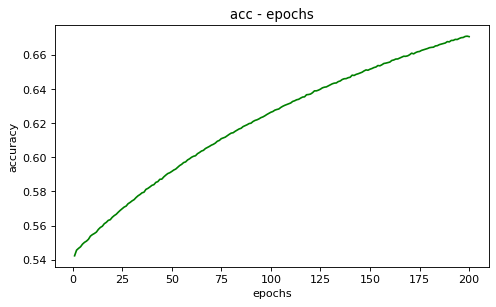

In [18]:
from matplotlib import pyplot as plt
acc = history.history['acc']
plt.figure(figsize=(7,4),dpi=80) #图片大小、像素
x = range(1,201) #横坐标
plt.plot(x, acc, label = 'acc', color='green')
plt.xlabel('epochs') #x轴标题
plt.ylabel('accuracy') #y轴标题
plt.title("acc - epochs") #标题

Text(0.5, 1.0, 'loss - epochs')

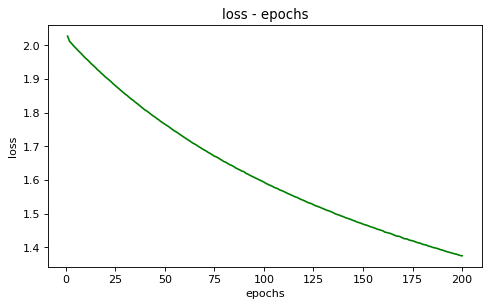

In [19]:
loss = history.history['loss']
plt.figure(figsize=(7,4),dpi=80) #图片大小、像素
x = range(1,201) #横坐标
plt.plot(x, loss, label = 'loss', color='green')
plt.xlabel('epochs') #x轴标题
plt.ylabel('loss') #y轴标题
plt.title("loss - epochs") #标题

### 根据以上网络结构编写回复生成器

In [15]:
#构造回复生成器模型
encoder_model = keras.models.Model(encoder_inputs, encoder_states)
thought_input = [keras.layers.Input(shape=(num_neurons, )), keras.layers.Input(shape=(num_neurons, ))]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=thought_input)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.models.Model([decoder_inputs] + thought_input, [decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 3417)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  3762176     input_2[0][0]                    
                                                                 input_3[0][0]              

In [16]:
#建立基于字符的翻译器
def decode_sequence(input_seq):
    thought = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, output_vocab_size))
    target_seq[0, 0, target_token_index[stop_token]] = 1
    stop_condition = False
    generated_sequence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + thought)
        generated_token_idx = np.argmax(output_tokens[0, -1, :])
        generated_char = reverse_target_char_index[generated_token_idx]
        generated_sequence += generated_char
        if (generated_char == stop_token):  #生成停止符就停止
            stop_condition = True
        target_seq = np.zeros((1, 1, output_vocab_size))
        target_seq[0, 0, generated_token_idx] = 1
        thought = [h,c]
    return generated_sequence
#生成回复
def response(input_text):
    input_seq = np.zeros((1, max_encoder_seq_length, input_vocab_size), dtype='float32')
    for t, char in enumerate(input_text):
        input_seq[0, t, input_token_index[char]] = 1
    decoded_sentence = decode_sequence(input_seq)
    print('Bot Reply (Decoded sentence):', decoded_sentence)

### 聊天测试

In [17]:
response('刚刚升入大学，我感觉就喜欢一个女孩子，怎么办？')

Bot Reply (Decoded sentence): 你好呀～非常理解你的困扰，抱抱你～关于“阅读”，在这个平台上上，我觉得题主对于自己与异性接受来的是有



In [20]:
response('我要通过这种方式和父亲断绝关系！')

Bot Reply (Decoded sentence): 你好呀～非常理解你的心情，抱抱你～我们先来看看你的问题：1.你的父母一定很难受，父母离婚，我想成为



In [21]:
response('期末周太短了，任务太多了，天天熬夜好焦虑')

Bot Reply (Decoded sentence): 题主你好看了你的描述，感觉到你的焦虑，给你一个温暖的抱抱。过于在敏感中，可是一直在集体里不舒服，但

